<a href="https://colab.research.google.com/github/Norod/my-colab-experiments/blob/master/fun_with_stylegan2_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd /content/
!pip install typeguard
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan2
!git clone https://github.com/kylemcdonald/python-utils.git utils

/content
fatal: destination path 'stylegan2' already exists and is not an empty directory.
/content/stylegan2
fatal: destination path 'utils' already exists and is not an empty directory.


In [6]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
from dnnlib.tflib.autosummary import autosummary

from utils.imutil import imshow, imresize
from utils.mosaic import make_mosaic

tflib.init_tf()

# Load pre-trained network.
url = 'https://norod78.s3.amazonaws.com/models/stylegan2-cat-config-f.pkl'
with dnnlib.util.open_url(url, cache_dir='/tmp/') as f:
    _G, _D, Gs = pickle.load(f)
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [7]:
!ls /tmp/

183fb0349a1bf65dbcea12049186714b_https___norod78.s3.amazonaws.com_models_stylegan2-cat-config-f.pkl


In [0]:
from PIL import Image

# Pick latent vector.
#random_seed = 1000
random_seed = None
rnd = np.random.RandomState(random_seed)
latents = rnd.randn(1, Gs.input_shape[1])

!mkdir './out'

In [9]:


qnumber_of_images = 30  #Actual number of video clip frames is qnumber_of_images * 4

# Generate image.
all = []
counter = 0
reverse_counter = (qnumber_of_images * 2) - 1
truncation_psi_vector_1 = (np.logspace(-8,1,num = qnumber_of_images, base=2.0) - 2)
truncation_psi_vector_2 = np.absolute(np.flip(truncation_psi_vector_1))
truncation_psi_vector = truncation_psi_vector_1 + truncation_psi_vector_2
for i in truncation_psi_vector:
  print(i)
  fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
  images = Gs.run(latents, None, truncation_psi=i, randomize_noise=True, output_transform=fmt)
  all.append(images[0])
  im = Image.fromarray(images[0])
  im.save('./out/StyleGanImg_' + str(counter) + '.jpg')
  if (reverse_counter > counter):
    im.save('./out/StyleGanImg_' + str(reverse_counter) + '.jpg')
  counter = counter + 1
  reverse_counter = reverse_counter - 1
  

-1.99609375
-1.6080541977119958
-1.2947136311635863
-1.0415164324250137
-0.8367008250805428
-0.6707525041061007
-0.5359626675971128
-0.4260699195822544
-0.33596940922470253
-0.2614756950462376
-0.19912831849948964
-0.14603105519215043
-0.09971737649586321
-0.058035871824215324
-0.019050309097777163
0.019050309097777163
0.058035871824215324
0.09971737649586321
0.14603105519215043
0.19912831849948964
0.2614756950462376
0.33596940922470253
0.4260699195822544
0.5359626675971128
0.6707525041061007
0.8367008250805428
1.0415164324250137
1.2947136311635863
1.6080541977119958
1.99609375


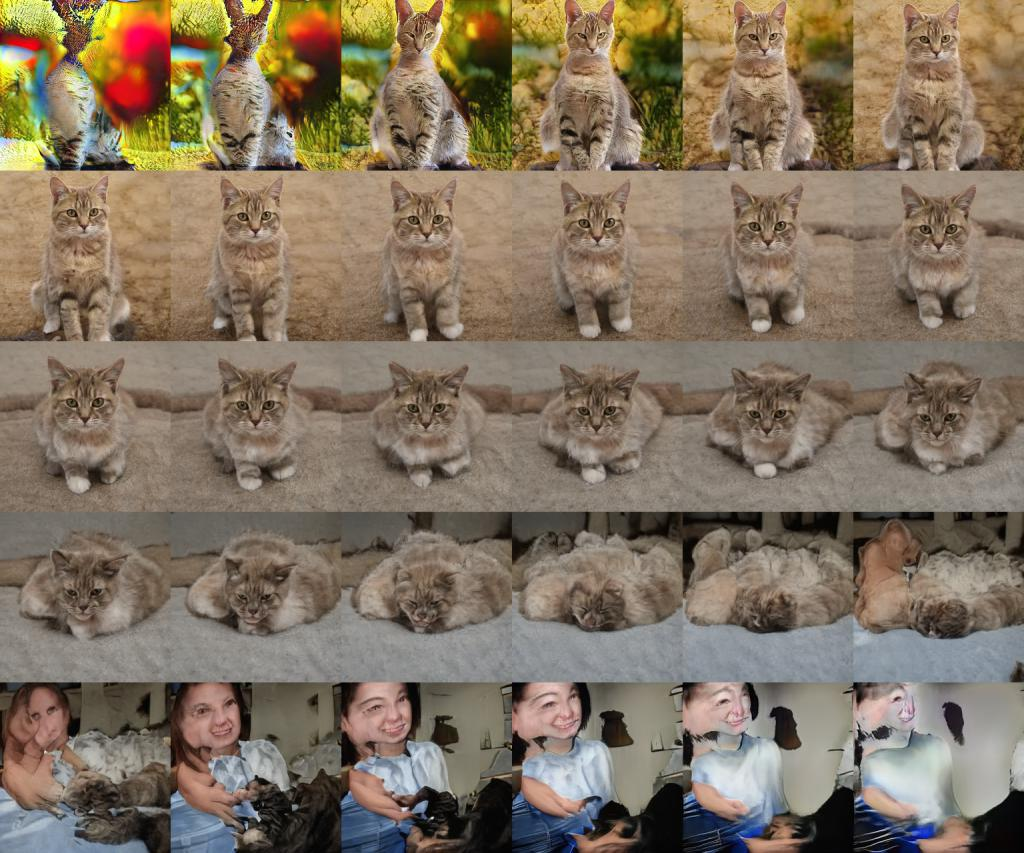

In [10]:
mosaic = make_mosaic(np.asarray(all))
mosaic = imresize(mosaic, max_side=1024) # comment this out for higher res
imshow(mosaic, retina=True, fmt='jpg')

In [11]:
!ffmpeg -f image2  -framerate 8 -i "./out/StyleGanImg_%01d.jpg" -b:v 8192k -r 30 -y -c:v libx264 StyleGanImg_all.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [12]:
!ls -latr /content/stylegan/StyleGanImg_all.mp4

from IPython.display import HTML
from base64 import b64encode
mp4 = open('StyleGanImg_all.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

ls: cannot access '/content/stylegan/StyleGanImg_all.mp4': No such file or directory


In [0]:
#import shutil
#shutil.make_archive('StyleGanImg_all', 'zip', './out/')

#!rm -rf './out'